### Курсовая работа. Классическое машинное обучение
### Раздел 3.2. Классификация: превышает ли значение CC50 медианное значение выборки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [2]:
# Загрузить данные
df = pd.read_csv('cc50.csv')
display(df.head())
print(df.shape)

,MaxAbsEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,MaxPartialCharge,MinPartialCharge,FpDensityMorgan1,BCUT2D_MWHI,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea,"CC50, mM"
0,-1.788262,1.268590,0.870224,-0.748934,1.097097,0.219317,-1.590886,1.549443,-2.056082,-0.588938,...,-0.208596,-0.11427,-0.0988,-0.032791,-0.032791,-0.243224,-0.280704,2.292130,-0.080539,175.482382
1,-2.133320,2.150705,0.962811,-0.539712,1.279553,0.251255,-1.795634,1.286626,-2.205560,-0.578681,...,-0.208596,-0.11427,-0.0988,-0.032791,-0.032791,-0.243224,-0.280704,2.292130,-0.080539,5.402819
2,-2.539798,2.207023,0.968722,-1.474490,1.037941,0.711670,-1.149492,1.125802,-2.392406,-0.553258,...,-0.208596,-0.11427,-0.0988,-0.032791,-0.032791,-0.243224,-0.280704,2.292130,-0.080539,161.142320
3,-1.787268,1.288909,0.872357,-0.932208,1.011964,0.330428,-1.590886,1.549443,-2.148861,-0.589009,...,-0.208596,-0.11427,-0.0988,-0.032791,-0.032791,-0.243224,-0.280704,3.111943,-0.080539,107.855654
4,-1.771076,0.566304,0.796513,-0.694778,0.585080,0.869343,-1.401150,2.029111,-2.235455,-0.588345,...,-0.208596,-0.11427,-0.0988,-0.032791,-0.032791,-0.243224,-0.280704,-0.167309,-0.080539,139.270991


(931, 146)


In [3]:
SEED = 42

In [4]:
# Разделить данные на признаки и целевую переменную
X = df.drop('CC50, mM', axis=1)
y = df['CC50, mM']

# Разделить данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

print(f'Train dataset size: {X_train.shape}, {y_train.shape}')
print(f'Train dataset size: {X_test.shape}, {y_test.shape}')

# Получить медианное значение целевой переменной
MEDIAN = y_train.median()

Train dataset size: (651, 145), (651,)
Train dataset size: (280, 145), (280,)


Условием настоящей задачи является определение, превысит ли значение целевой переменной ее медианное значение. В конечном итоге перед нами стоит задача классификации с двумя возможными метками класса - превысит или нет.

In [5]:
y_train = (y_train > MEDIAN).astype(int)
y_test = (y_test > MEDIAN).astype(int)

C:\Users\Ronikari\AppData\Local\Temp\ipykernel_4176\2314283226.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='CC50, mM', data=y_data, palette='hls')


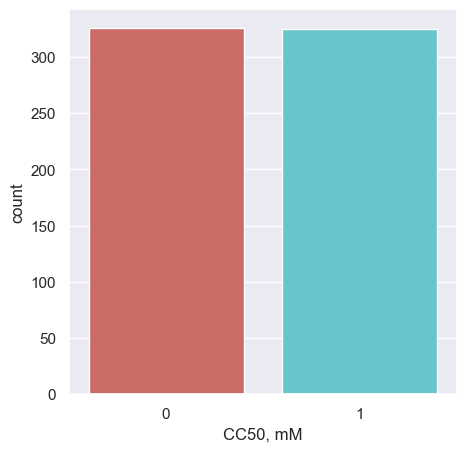

In [20]:
# Проанализировать распределение меток класса
sns.set(rc = {'figure.figsize':(5, 5)})
y_data = pd.DataFrame(y_train)
sns.countplot(x='CC50, mM', data=y_data, palette='hls')
plt.show()

В рамках настоящей задачи будем использовать следующие модели:
- `LogisticRegression`;
- `DecisionTree`;
- `kNN`;
- `RandomForest`;
- `SVC`;
- `XGBoost`;
- `CatBoost`.
  
Для анализа эффективности моделей проверим следующие метрики:
- Accuracy;
- Precision;
- F1;
- Recall.

In [6]:
# Инициализация моделей и метрик
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=SEED),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=SEED),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=False)
}
metrics = {
    'Accuracy': lambda y_true, y_pred: accuracy_score(y_true, y_pred),
    'Precision': lambda y_true, y_pred: precision_score(y_true, y_pred, average='binary'),
    'F1': lambda y_true, y_pred: f1_score(y_true, y_pred, average='binary'),
    'Recall': lambda y_true, y_pred: recall_score(y_true, y_pred, average='binary')
}

In [7]:
# Создать список для хранения результатов
results = []

In [8]:
for name, model in models.items():
    # Осуществить стратифицированную k-кратную перекрестную проверку
    cv_accuracy = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=1)
    cv_precision = cross_val_score(model, X_train, y_train, cv=5, scoring='precision', n_jobs=1)
    cv_f1 = cross_val_score(model, X_train, y_train, cv=5, scoring='f1', n_jobs=1)
    cv_recall = cross_val_score(model, X_train, y_train, cv=5, scoring='recall', n_jobs=1)
    
    # Обучить модель на обучающей выборке и сделать прогноз на тестовой выборке
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    test_accuracy = metrics['Accuracy'](y_test, y_pred)
    test_precision = metrics['Precision'](y_test, y_pred)
    test_f1 = metrics['F1'](y_test, y_pred)
    test_recall = metrics['Recall'](y_test, y_pred)
    
    # Сохранить результаты
    results.append({
        'Model': name,
        'CV Accuracy': cv_accuracy.mean(),
        'CV Precision': cv_precision.mean(),
        'CV F1': cv_f1.mean(),
        'CV Recall': cv_recall.mean(),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test F1': test_f1,
        'Test Recall': test_recall
    })

In [9]:
# Записать результаты в DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
display(results_df.round(4))

,Model,CV Accuracy,CV Precision,CV F1,CV Recall,Test Accuracy,Test Precision,Test F1,Test Recall
6,CatBoost,0.7235,0.7193,0.7273,0.7385,0.7714,0.7310,0.7681,0.8092
2,RandomForest,0.7281,0.7332,0.7269,0.7231,0.7679,0.7463,0.7547,0.7634
1,DecisionTree,0.6713,0.6710,0.6718,0.6738,0.7643,0.7407,0.7519,0.7634
5,XGBoost,0.7266,0.7253,0.7292,0.7354,0.7571,0.7368,0.7424,0.7481
4,SVC,0.7281,0.7207,0.7322,0.7446,0.7571,0.7059,0.7606,0.8244
0,LogisticRegression,0.7189,0.7193,0.7200,0.7231,0.7500,0.7075,0.7482,0.7939
3,KNN,0.7143,0.7132,0.7168,0.7231,0.7464,0.7239,0.7321,0.7405


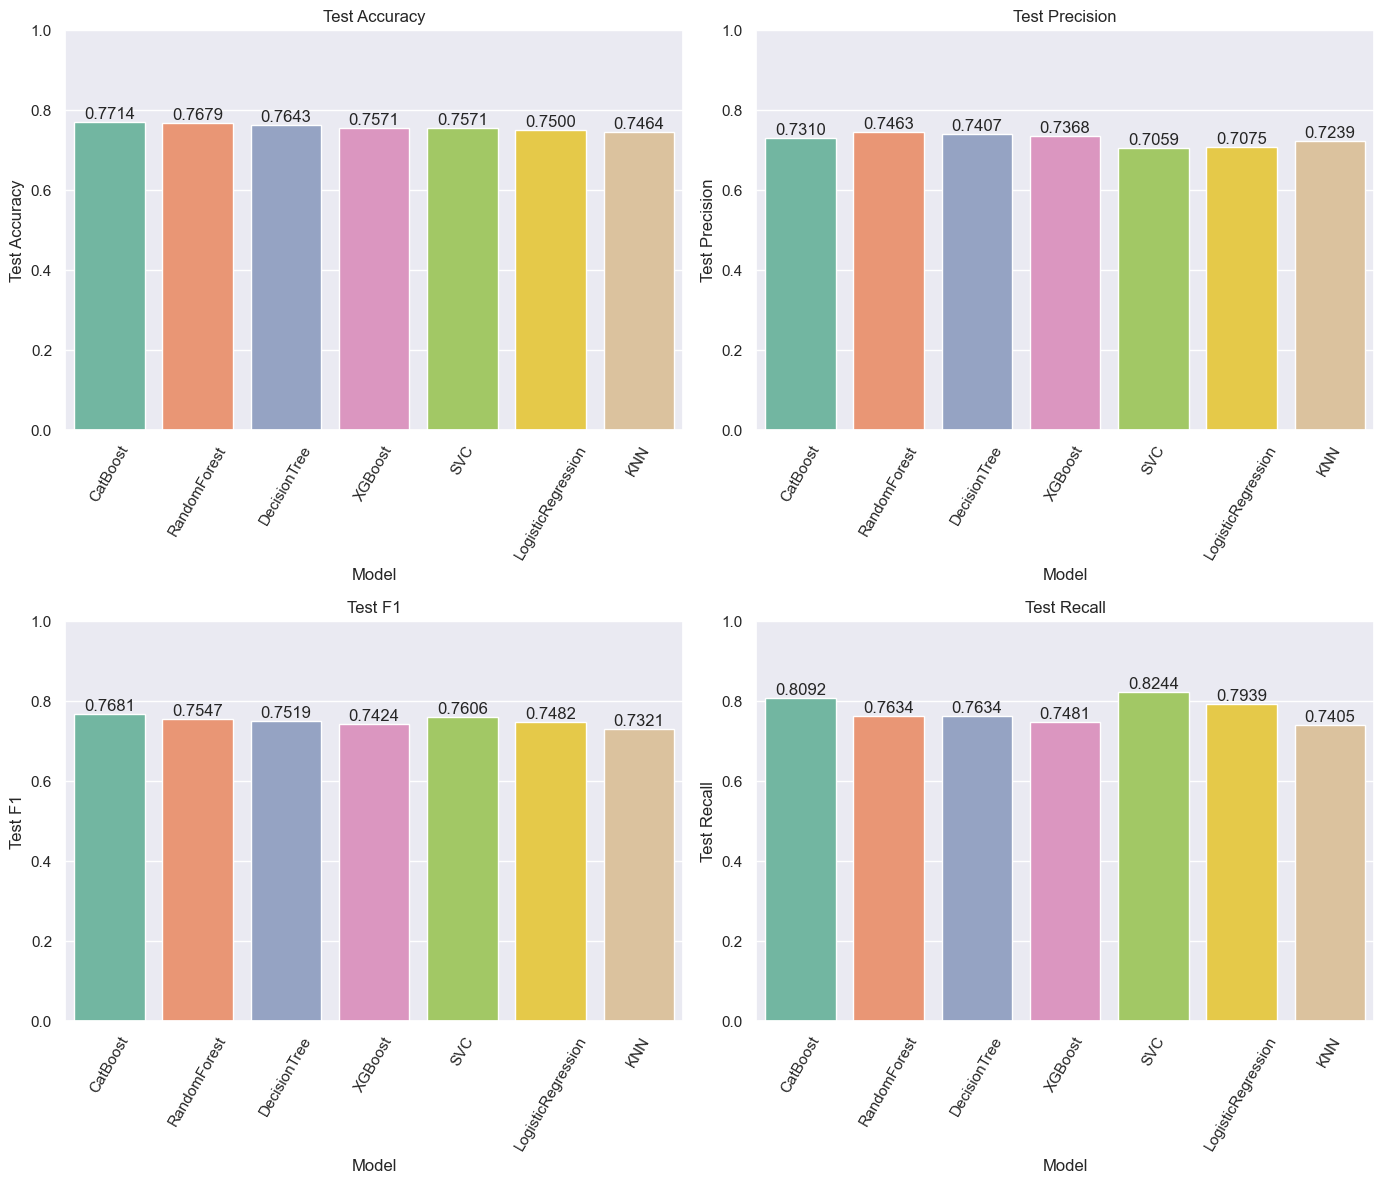

In [21]:
# Визуализация полученных метрик
plt.figure(figsize=(14, 12))
for i, metric in enumerate(list(metrics.keys())):
    plt.subplot(2, 2, i + 1)
    ax = sns.barplot(x='Model', y=f'Test {metric}', data=results_df, palette="Set2", hue='Model', legend=False)
    [ax.bar_label(ax.containers[x], fmt='%.4f', fontsize=12) for x in range(0, len(list(models.keys())))]
    plt.title(f'Test {metric}')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

По совокупности полученных метрик наиболее эффективной моделью является `RandomForest`.   
Теперь используем `GridSearchCV` и подберем наиболее оптимальные гиперпараметры для всех моделей, после чего перепроверим метрики.

In [11]:
# Конфигурация гиперпараметров для GridSearchCV
params = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [100, 250, 500, 1000]
    },
    'DecisionTree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    },
    'RandomForest': {
        'n_estimators': [100, 200, 300, 400, 500, 1000],
        'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10]
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'metric': ['euclidean', 'manhattan', 'minkowski']
    },
    'SVC': {
        'C': [0.01, 0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto']
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300, 400, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
        'max_depth': [None, 5, 10, 20]
    },
    'CatBoost': {
        'n_estimators': [50, 100, 200, 400, 500, 1000]
    }
}

# Повторная инициализация моделей
models = {
    'LogisticRegression': LogisticRegression(random_state=SEED),
    'DecisionTree': DecisionTreeClassifier(random_state=SEED),
    'RandomForest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(random_state=SEED),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=SEED),
    'CatBoost': CatBoostClassifier(random_state=SEED, verbose=False)
}

In [12]:
# Создать список для хранения результатов
results_grid = []

# Создать словарь для хранения предсказанных значений
pred_values = {}

In [13]:
for name, model in models.items():
    # Запустить поиск лучших гиперпараметров
    grid = GridSearchCV(model, param_grid=params[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Лучшая модель
    best_model = grid.best_estimator_
    print(f'Лучшие параметры для {name}: {grid.best_params_}')
    
    # Осуществить стратифицированную k-кратную перекрестную проверку
    cv_accuracy = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=1)
    cv_precision = cross_val_score(best_model, X_train, y_train, cv=5, scoring='precision', n_jobs=1)
    cv_f1 = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1', n_jobs=1)
    cv_recall = cross_val_score(best_model, X_train, y_train, cv=5, scoring='recall', n_jobs=1)
    
    # Обучить и оценить качество лучшей модели на тестовой выборке
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    pred_values[name] = y_pred
    
    test_accuracy = metrics['Accuracy'](y_test, y_pred)
    test_precision = metrics['Precision'](y_test, y_pred)
    test_f1 = metrics['F1'](y_test, y_pred)
    test_recall = metrics['Recall'](y_test, y_pred)
    
    # Сохранить результаты
    results_grid.append({
        'Model': name,
        'CV Accuracy': cv_accuracy.mean(),
        'CV Precision': cv_precision.mean(),
        'CV F1': cv_f1.mean(),
        'CV Recall': cv_recall.mean(),
        'Test Accuracy': test_accuracy,
        'Test Precision': test_precision,
        'Test F1': test_f1,
        'Test Recall': test_recall
    })

Лучшие параметры для LogisticRegression: {'C': 1, 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Лучшие параметры для DecisionTree: {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 5}
Лучшие параметры для RandomForest: {'max_depth': 9, 'n_estimators': 100}
Лучшие параметры для KNN: {'metric': 'euclidean', 'n_neighbors': 3}
Лучшие параметры для SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Лучшие параметры для XGBoost: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200}
Лучшие параметры для CatBoost: {'n_estimators': 100}


In [14]:
# Записать результаты в DataFrame
results_grid_df = pd.DataFrame(results_grid)
results_grid_df.sort_values(by='Test Accuracy', ascending=False, inplace=True)
display(results_grid_df.round(4))

,Model,CV Accuracy,CV Precision,CV F1,CV Recall,Test Accuracy,Test Precision,Test F1,Test Recall
2,RandomForest,0.7404,0.7327,0.7458,0.7600,0.7750,0.7361,0.7709,0.8092
6,CatBoost,0.7281,0.7266,0.7304,0.7354,0.7643,0.7241,0.7609,0.8015
0,LogisticRegression,0.7281,0.7264,0.7301,0.7354,0.7607,0.7162,0.7599,0.8092
1,DecisionTree,0.7189,0.7303,0.7147,0.7015,0.7571,0.7561,0.7323,0.7099
5,XGBoost,0.7389,0.7367,0.7423,0.7508,0.7571,0.7368,0.7424,0.7481
4,SVC,0.7420,0.7286,0.7496,0.7723,0.7429,0.6980,0.7429,0.7939
3,KNN,0.7250,0.7344,0.7216,0.7138,0.7000,0.6741,0.6842,0.6947


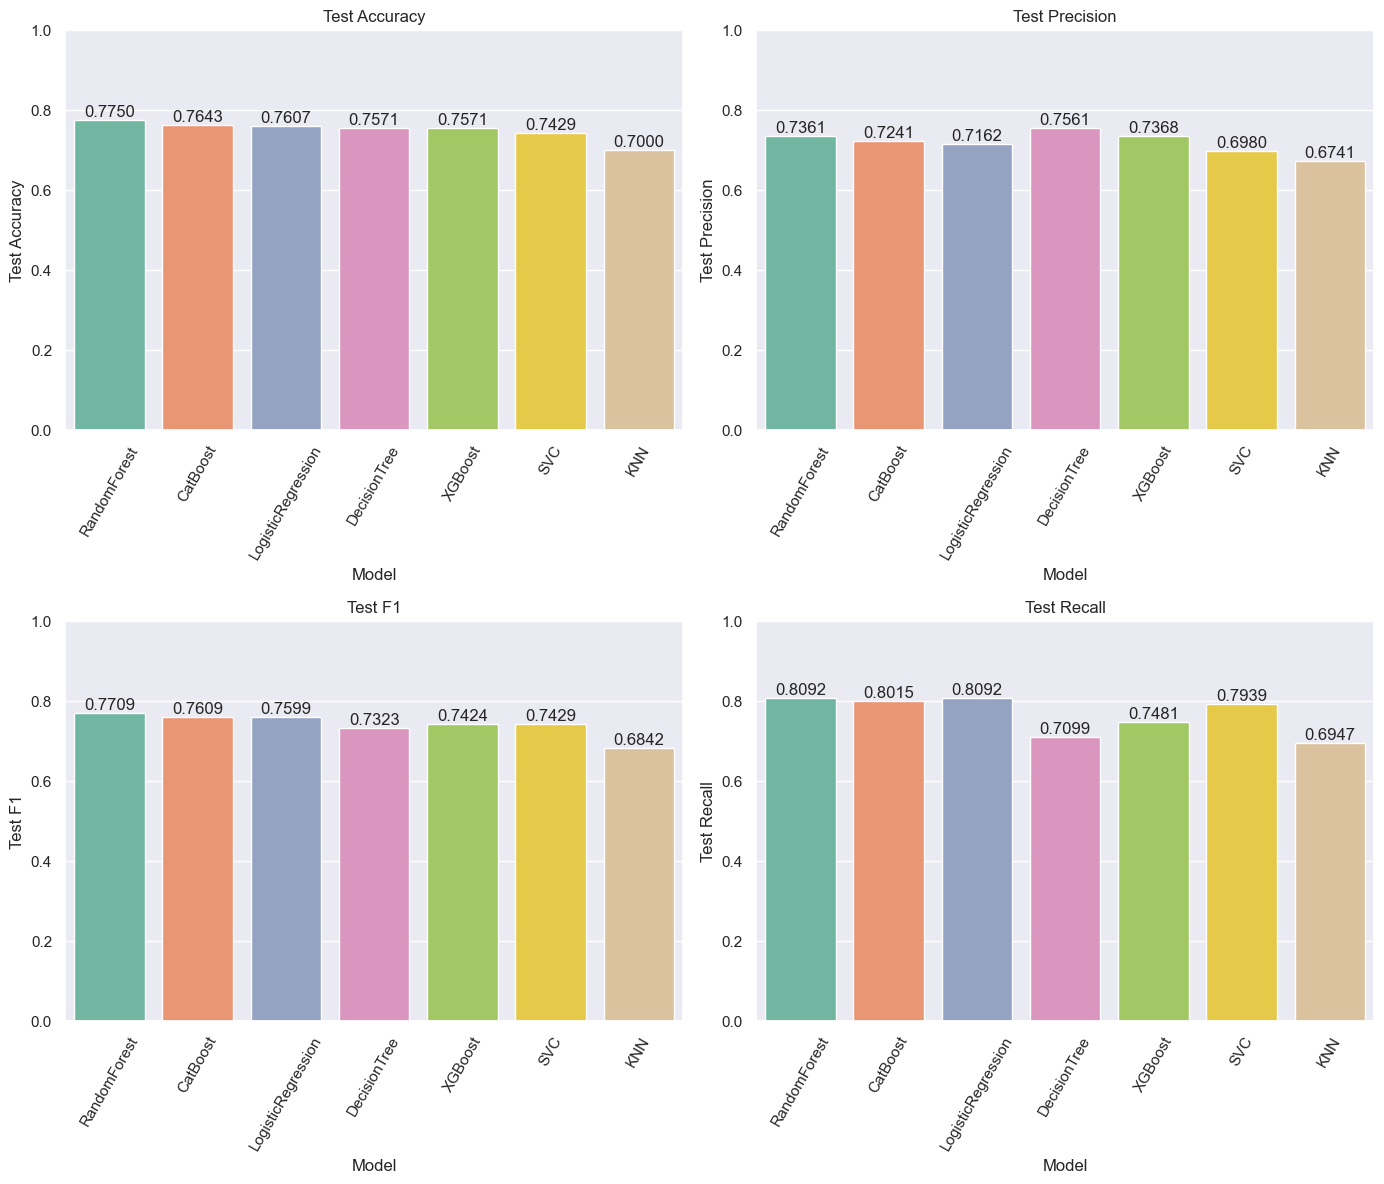

In [22]:
# Визуализация полученных метрик
plt.figure(figsize=(14, 12))
for i, metric in enumerate(list(metrics.keys())):
    plt.subplot(2, 2, i + 1)
    ax = sns.barplot(x='Model', y=f'Test {metric}', data=results_grid_df, palette="Set2", hue='Model', legend=False)
    [ax.bar_label(ax.containers[x], fmt='%.4f', fontsize=12) for x in range(0, len(list(models.keys())))]
    plt.title(f'Test {metric}')
    plt.ylim(0.0, 1.0)
    plt.xticks(rotation=60)

plt.tight_layout()
plt.show()

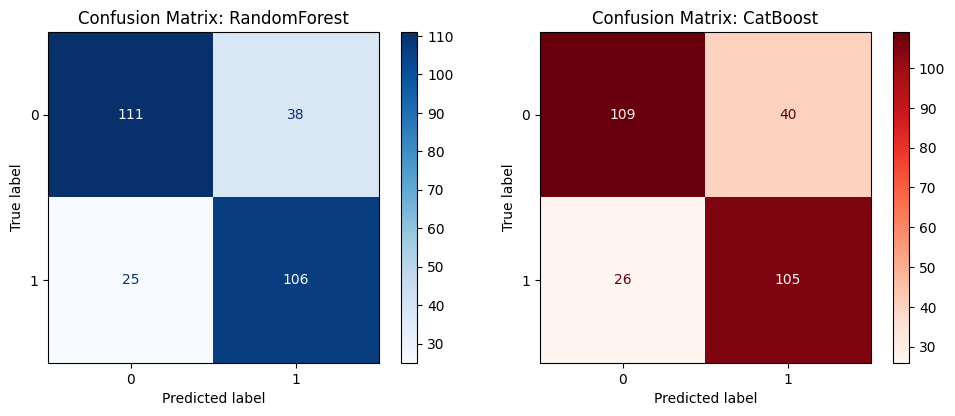

In [ ]:
# Построить матрицы ошибок для лучших моделей
cm_rf = confusion_matrix(y_test, pred_values['RandomForest'])
cm_cat = confusion_matrix(y_test, pred_values['CatBoost'])

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=100)
cm_display = ConfusionMatrixDisplay(cm_rf)
cm_display.plot(ax=axes[0], cmap='Blues')
cm_display = ConfusionMatrixDisplay(cm_cat)
cm_display.plot(ax=axes[1], cmap='Reds')

axes[0].set_title('Confusion Matrix: RandomForest')
axes[1].set_title('Confusion Matrix: CatBoost')

plt.tight_layout()
plt.show()

По совокупности полученных метрик и с подбором гиперпараметров посредством `GridSearchCV` наиболее эффективными моделями являются `RandomForest` и `CatBoost`.   

**Выводы**  
  
1. В рамках настоящей задачи были использованы следующие модели:
- `LogisticRegression`;
- `DecisionTree`;
- `kNN`;
- `RandomForest`;
- `SVC`;
- `XGBoost`;
- `CatBoost`.
  
   Наиболее оптимальными моделями по совокупности использованных метрик принимаются `RandomForest` и `CatBoost`.
2. Метрики всех моделей оказались хорошими. В качестве рекомендаций по дальнейшему улучшению предсказательной способности моделей требуется более глубокая обработка исходных данных. Как показал ранее выполненный EDA, в данных присутствует существенное число выбросов, однако для их эффективного устранения требуется знание специфики отрасли и понимание ключевой важности тех или иных признаков, что не было выполнено в настоящей работе.